<a href="https://colab.research.google.com/github/en-abhat2/Particle-Distribution-Prediction/blob/main/Particle_Size_distribution_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd # Read write process excels
import numpy as np # Numerical library
import matplotlib.pyplot as plt # Plotting
import scipy.stats as stats

from scipy.interpolate import interp1d

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

import torch.nn.functional as F
from sklearn.model_selection import train_test_split

from google.colab import drive
drive.mount('/content/gdrive/')
%cd /content/gdrive/MyDrive/Bareen/Particle_Size_Distribution

from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report

from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression

Mounted at /content/gdrive/
/content/gdrive/MyDrive/Bareen/Particle_Size_Distribution


In [ ]:
xls = pd.ExcelFile('dQ3(x)_Q3(x)_all data.xlsx')  # Creates a proxy placeholder

# Dictionary data structure of pandas dataframes
dfs = {(1,1):pd.read_excel(xls, 'Esa1_portion 1_dQ3(x)'),   # Read one sheet at a time
       (1,2):pd.read_excel(xls, 'Esa1_portion 2_dQ3(x)'),
       (1,3):pd.read_excel(xls, 'Esa1_portion 3_dQ3(x)'),
       (2,1):pd.read_excel(xls, 'Esa2_portion 1_dQ3(x)'),
       (2,2):pd.read_excel(xls, 'Esa2_portion 2_dQ3(x)'),
       (2,3):pd.read_excel(xls, 'Esa2_portion 3_dQ3(x)'),
       (3,1):pd.read_excel(xls, 'Esa3_Portion 1_dQ3(x)'),
       (3,2):pd.read_excel(xls, 'Esa3_Portion 2_dQ3(x)'),
       (3,3):pd.read_excel(xls, 'Esa3_Portion 3_dQ3(x)')}

main_cols = { 1: ['Hexagon1_'+str(i+1) for i in range(9)],
         2: ['Hexagon2_'+str(i+1) for i in range(9)],
         3: ['Hexagon3_'+str(i+1) for i in range(9)]}

# Particle size array (x-axis)
sizes = dfs[(1,1)].iloc[:,0].values
log_sizes = np.log(sizes)

# Pandas Dataframe is created using pd

# Features
xls2 = pd.ExcelFile('Data_emulsion.xlsx')  # Creates a proxy placeholder
exp_design = pd.read_excel(xls2, 'DOE')

all_designs = exp_design.iloc[1:13,[1,2,4,5,7,8]].values
des_ids = [6,3,9,5,10,1,8,2,4,11,7,12]
sorted_ids = np.argsort(des_ids)
all_designs = all_designs[sorted_ids]
all_designs = all_designs[:9]
exp1_designs = all_designs[:,:2]
exp2_designs = all_designs[:,2:4]
exp3_designs = all_designs[:,4:]

exp_des = {0: exp1_designs, 1: exp2_designs, 2: exp3_designs}

In [ ]:
target_bin_centres = np.empty((81, 108))  # Don't need this - x-axis (Particle Sizes)
target_bin_heights = np.empty((81, 108))  # Y-axis - 108 dimensional distribution of particle sizes
input_features = np.empty((81,4))         # Input Features - A, B, Shape, Portion. (2 continuous, 2 categorical with 3 classes each)
sample_keys = []

id_count = 0
for shape in [0,1,2]:
  for portion in [0,1,2]:

    df = dfs[(shape+1, portion+1)]
    req_col = main_cols[shape+1]

    df_cols = list(df.columns)

    for c in range(len(req_col)):

      all_cols = [col for col in df_cols if col.startswith(req_col[c])] # storing 5 repetiions column names
      hex1 = df[all_cols].values

      non_nan_count = hex1.shape[1]

      for k in range(hex1.shape[1]):
        if np.isnan(hex1[:,k]).all():
          hex1[:,k] = 0
          non_nan_count -= 1
        elif np.isnan(hex1[:,k]).any():
          hex1[:,k] = np.nan_to_num(hex1[:,k], nan=0)

      hex1 = hex1.sum(axis = -1)/non_nan_count if non_nan_count > 0 else np.ones(hex1.shape[0])

      hex1 = hex1/np.sum(hex1)

      target_bin_centres[id_count] = np.log(sizes)
      target_bin_heights[id_count] = hex1
      input_features[id_count] = np.array([exp_des[shape][c,0], exp_des[shape][c,1], shape, portion])
      sample_keys.append((shape, portion, c))
      id_count += 1

In [ ]:
# This function takes inputs x: log_sizes, pdf: empirical distribution (dQ), num_quantiles: the level of quantization
# And output is the quantiles themselves ( particle sizes less than each quantile percentage )

def get_equidistant_quantiles(x, pdf, num_quantiles = 20):

  # dQ3 -> Q3
  cdf = np.cumsum(pdf)
  cdf /= cdf[-1]

  # Interpolate inverse CDF
  inv_cdf = interp1d(cdf, x, bounds_error=False, fill_value="extrapolate")
  probs = np.linspace(0.01, 1, num_quantiles)
  quantiles = inv_cdf(probs)

  return quantiles

# Does the reverse of the previous function. It takes the quantiles and the corresponding probability values, the log_sizes
# And outputs the reconstructed dQ3 (empirical distribution)

def reconstruct_pdf(quantile, probs, x_dense, num_quantiles):
  dx = np.diff(quantile)
  dp = np.diff(probs)

  # Use chain rule: pdf(x) ≈ dp/dx
  pdf_est = dp / dx
  x_mid = 0.5 * (quantile[1:] + quantile[:-1])
  pdf_interp = interp1d(x_mid, pdf_est, kind='cubic', bounds_error=False, fill_value=0)


  pdf_dense = pdf_interp(x_dense)
  pdf_dense[pdf_dense < 0] = 0
  pdf_dense /= np.sum(pdf_dense)
  return pdf_dense

def reconstruct_pdf_from_cdf(quantile, probs, x_dense, num_quantiles):

  cdf_interp = interp1d(quantile, probs, kind='slinear', fill_value="extrapolate")

  dx = x_dense[1] - x_dense[0]

  # Evaluate interpolated CDF
  cdf_vals = cdf_interp(x_dense)

  # Numerically differentiate the CDF to get PDF
  pdf_est = np.gradient(cdf_vals, dx)
  pdf_est[pdf_est < 0] = 0
  pdf_est /= np.sum(pdf_est)

  return pdf_est

In [ ]:
num_quantiles = 100
num_classes = 20
num_samples = 81

In [ ]:
sample_quantiles = np.empty((num_samples, num_quantiles))  # Placeholder for the generated quantile values
recon_pdfs = np.empty((num_samples, len(log_sizes)))       # Placeholder for reconstructed dQ3 using reconstruct_pdfs function
#rec_pdf_from_cdf = np.empty((81, len(log_sizes))) # Placeholder for reconstructed dQ3 using reconstruct_pdf_from_cdf function

for i in range(target_bin_heights.shape[0]):  # Looping over all the samples, i.e., 81

  sample_quantiles[i] = get_equidistant_quantiles(log_sizes, target_bin_heights[i], num_quantiles)

  probs = np.linspace(0.01, 1, num_quantiles)
  recon_pdfs[i] = reconstruct_pdf(sample_quantiles[i], probs, log_sizes, num_quantiles)
  #rec_pdf_from_cdf[i] = reconstruct_pdf_from_cdf(sample_quantiles[i], probs, log_sizes, num_quantiles)

In [ ]:
def real_to_categorical(x, class_boundaries):

  lcb = class_boundaries[:-1]
  ucb = class_boundaries[1:]

  lcflag = lcb > x
  ucflag = ucb <= x

  return (1-lcflag)*(1-ucflag)

(8100, 4) (8100, 20)
(6480, 9) (6480, 20) (1620, 9) (1620, 20)
(6480,) (1620,)


/tmp/ipython-input-85-1231226716.py:39: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  all_labels[i] = np.where(y_categorical[i] == 1)[0].astype(int)
/tmp/ipython-input-85-1231226716.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  labels_train[i] = np.where(Y_train[i] == 1)[0].astype(int)
/tmp/ipython-input-85-1231226716.py:55: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  labels_test[i] = np.where(Y_test[i] == 1)[0].astype(int)


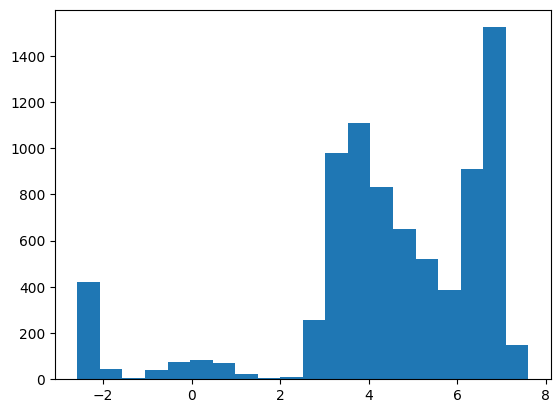

In [ ]:
ally_flat = sample_quantiles.reshape(-1)

hist = plt.hist(ally_flat, bins = num_classes)
class_boundaries = hist[1]

X_flat = np.repeat(input_features, num_quantiles, axis = 0)
y_flat = sample_quantiles.reshape(-1)
task_indices = np.arange(num_quantiles).reshape(1,-1).repeat(num_samples, axis = 0).reshape(-1)

cb = class_boundaries
cb[-1] = cb[-1] + 0.01
y_categorical = np.zeros((y_flat.shape[0], num_classes))

for n in range(y_categorical.shape[0]):

    y_categorical[n] = real_to_categorical(y_flat[n], cb).astype(int)
    assert np.sum(y_categorical[n]) == 1

print(X_flat.shape, y_categorical.shape)

# Two ways of processing the data: MLP: task and X are given separately
# Others where task and X are combined as fetures and given as input.

# One Hot Encoding of X
Xnew = np.zeros((X_flat.shape[0], 8))
Xnew[:,:2] = X_flat[:,:2]

for i in range(X_flat.shape[0]):
 Xnew[i,2:5][X_flat[i,2].astype(int)] = 1
 Xnew[i,5:][X_flat[i,3].astype(int)] = 1

# MinMax Scaling of X
Xnew[:,:2] = (Xnew[:,:2] - np.min(Xnew[:,:2], axis=0))/(np.max(Xnew[:,:2], axis=0) - np.min(Xnew[:,:2], axis=0))
Xnew = np.concatenate((Xnew, task_indices.reshape(-1,1)), axis = -1)

all_labels = np.zeros((Xnew.shape[0],))

for i in range(Xnew.shape[0]):
  all_labels[i] = np.where(y_categorical[i] == 1)[0].astype(int)


# X not one hot
Xnew_not_hot = np.concatenate((X_flat, task_indices.reshape(-1,1)), axis = -1)
Xnew_not_hot[:,:2] = (Xnew_not_hot[:,:2] - np.min(Xnew_not_hot[:,:2], axis=0))/(np.max(Xnew_not_hot[:,:2], axis=0) - np.min(Xnew_not_hot[:,:2], axis=0))

X_train, X_test, Y_train, Y_test, idx_train, idx_test = train_test_split(Xnew, y_categorical, np.arange(Xnew.shape[0]), test_size=0.2, random_state=42, stratify = all_labels)
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)
labels_train = np.zeros((X_train.shape[0],))
labels_test = np.zeros((X_test.shape[0],))

for i in range(X_train.shape[0]):
  labels_train[i] = np.where(Y_train[i] == 1)[0].astype(int)

for i in range(X_test.shape[0]):
  labels_test[i] = np.where(Y_test[i] == 1)[0].astype(int)

print(labels_train.shape, labels_test.shape)

In [ ]:
rf = RandomForestClassifier(n_estimators=300,random_state=42, class_weight='balanced')
#brf = BalancedRandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, labels_train)

#Evaluate performance
ypred_all = rf.predict(Xnew)
print(ypred_all.shape)
print(classification_report(all_labels, ypred_all))

ypred_test = rf.predict(X_test)
print(ypred_test.shape)
print(classification_report(labels_test, ypred_test))

(8100,)
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99       423
         1.0       0.94      0.96      0.95        46
         2.0       1.00      1.00      1.00         7
         3.0       0.95      0.98      0.96        42
         4.0       0.95      0.99      0.97        74
         5.0       0.98      0.95      0.96        84
         6.0       0.90      0.91      0.91        69
         7.0       0.90      0.90      0.90        21
         8.0       1.00      1.00      1.00         7
         9.0       0.91      0.83      0.87        12
        10.0       0.97      0.97      0.97       256
        11.0       0.99      0.99      0.99       979
        12.0       0.99      0.99      0.99      1109
        13.0       0.98      0.98      0.98       833
        14.0       0.97      0.98      0.98       651
        15.0       0.98      0.97      0.97       520
        16.0       0.96      0.97      0.97       387
        17.0       

In [ ]:
def cat2real(pred_labels, class_boundaries):

  if len(pred_labels.shape) == 1:
    pred_labels = pred_labels.reshape(-1,1)
  real_vals = np.zeros((pred_labels.shape[0], pred_labels.shape[1]))

  lcb = class_boundaries[:-1]
  ucb = class_boundaries[1:]


  for i in range(pred_labels.shape[0]):

    unique_labels, label_count = np.unique(pred_labels[i], return_counts = True)
    #print(unique_labels, label_count)

    sorted_ids = np.argsort(unique_labels)
    unique_labels = unique_labels[sorted_ids]
    label_count = label_count[sorted_ids]

    vals = []
    for j in range(len(unique_labels)):
      #print(unique_labels[j])
      #if label_count[j] > 1:
      vals.extend(np.linspace(lcb[int(unique_labels[j])], ucb[int(unique_labels[j])], label_count[j]+2)[1:-1])

    #print(vals)

    real_vals[i] = np.asarray(vals)

  return real_vals

6.250678241836147
0.19310089925316265


(array([493552., 327374., 304819., 280293., 256141., 171992.,  78686.,
         67284.,  73370.,  64115.]),
 array([5.36685423e-06, 1.00002748e-01, 2.00000130e-01, 2.99997512e-01,
        3.99994893e-01, 4.99992275e-01, 5.99989656e-01, 6.99987038e-01,
        7.99984420e-01, 8.99981801e-01, 9.99979183e-01]),
 <BarContainer object of 10 artists>)

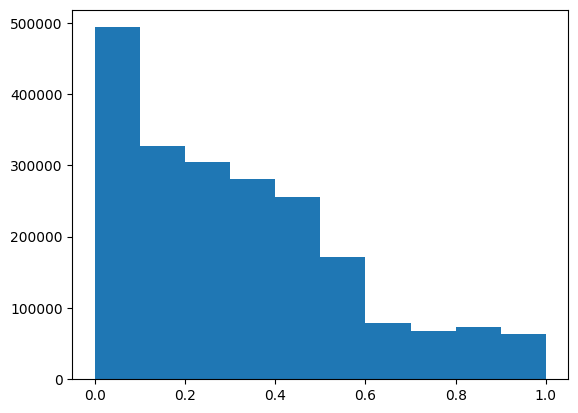

In [ ]:
pred_quantiles = cat2real(ypred_test, class_boundaries)
abs_err = np.abs(pred_quantiles - y_flat[idx_test.astype(int)])/np.abs(y_flat[idx_test.astype(int)])
print(np.mean(abs_err))
print(1 - np.size(abs_err[abs_err<1])/np.size(abs_err))
plt.hist(abs_err[abs_err<1], bins = 10)
#print(ape)

In [ ]:
ypred_all_unflat = ypred_all.reshape(num_samples, num_quantiles)
pred_quantiles = cat2real(ypred_all_unflat, class_boundaries)
ape = np.mean(np.abs(pred_quantiles - sample_quantiles)/np.abs(sample_quantiles))
print(ape)

0.07060513661198653


In [ ]:
recon_pdf_true = np.empty((num_samples, len(log_sizes)))
recon_pdf_pred = np.empty((num_samples, len(log_sizes)))

for i in range(target_bin_heights.shape[0]):  # Looping over all the samples, i.e., 81

  sample_quantiles[i] = get_equidistant_quantiles(log_sizes, target_bin_heights[i], num_quantiles)

  probs = np.linspace(0.01, 1, num_quantiles)
  recon_pdf_true[i] = reconstruct_pdf(sample_quantiles[i], probs, log_sizes, num_quantiles)
  recon_pdf_pred[i] = reconstruct_pdf(pred_quantiles[i], probs, log_sizes, num_quantiles)
  #rec_pdf_from_cdf[i] = reconstruct_pdf_from_cdf(sample_quantiles[i], probs, log_sizes, num_quantiles)

In [ ]:
recon_pdf_true.shape

(81, 108)

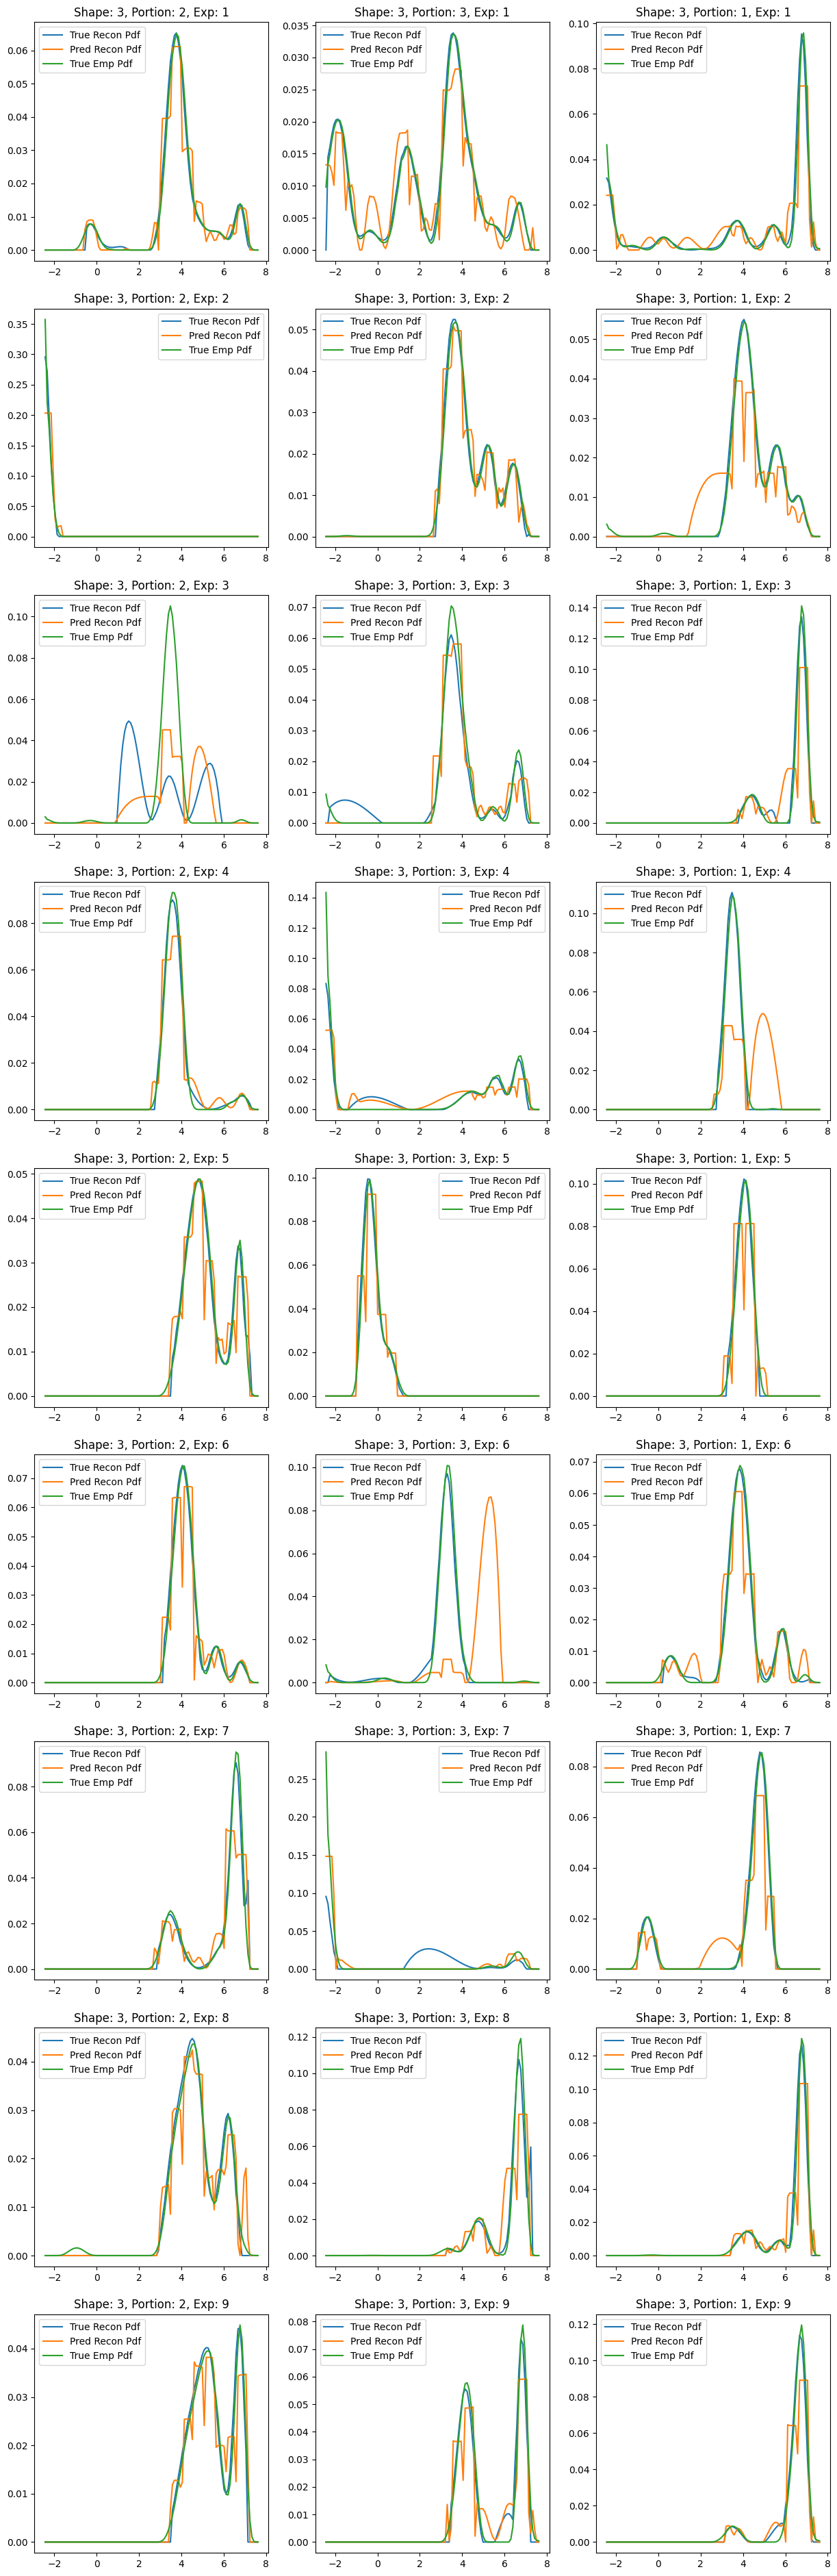

In [ ]:
fig, axs = plt.subplots(9, 3, figsize=(15, 48))
shape = 2
for portion in [0,1,2]:
  for c in range(9):
    idx = shape*27 + portion*9 + c

    axs[c,portion-1].plot(log_sizes, recon_pdf_true[idx], label='True Recon Pdf')
    axs[c,portion-1].plot(log_sizes, recon_pdf_pred[idx], label='Pred Recon Pdf')
    axs[c,portion-1].plot(log_sizes, target_bin_heights[idx], label='True Emp Pdf')
    axs[c,portion-1].set_title(f'Shape: {shape+1}, Portion: {portion+1}, Exp: {c+1}')
    axs[c,portion-1].legend()


In [ ]:
plt.plot(log_sizes, recon_pdf_true[0])
plt.plot(log_sizes, recon_pdf_pred[0])
plt.plot(log_sizes, target_bin_heights[0])